# Transpilation Technique Comparison

In [151]:
from networkx import barabasi_albert_graph, draw
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp
from qopt_best_practices.transpilation.cost_layer import get_cost_layer
from qiskit.circuit.library import QAOAAnsatz
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit_optimization.applications import Maxcut
from qiskit.providers.fake_provider import GenericBackendV2
from qopt_best_practices.qubit_selection import BackendEvaluator
from qiskit.transpiler import Layout
from qiskit.circuit.library import qaoa_ansatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import time
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    Commuting2qGateRouter,
)
from qiskit.transpiler import PassManager
from qopt_best_practices.transpilation.prepare_cost_layer import PrepareCostLayer
from qopt_best_practices.transpilation.swap_cancellation_pass import SwapToFinalMapping
from qiskit.circuit.library.standard_gates.equivalence_library import _sel
from qiskit.circuit.library import CXGate
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
    HighLevelSynthesis,
    InverseCancellation
)
from qopt_best_practices.transpilation.qaoa_construction_pass import QAOAConstructionPass
from test_annotated_ansatz import annotated_qaoa_ansatz, AnnotatedPrepareCostLayer, AnnotatedCommuting2qGateRouter


In [152]:
def get_problem_qopt(n=4, m=3):
    graph = barabasi_albert_graph(n=n, m=3, seed=42)
    local_correlators = build_max_cut_paulis(graph)
    cost_operator = SparsePauliOp.from_list(local_correlators)
    cost_layer = get_cost_layer(cost_operator)
    return cost_operator, cost_layer, graph

def get_problem_maxcut(n=4, elist = [(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (2, 3, 1.0)]):
    graph = nx.Graph()
    graph.add_nodes_from(np.arange(0, n, 1))
    # tuple is (i,j,weight) where (i,j) is the edge
    graph.add_weighted_edges_from(elist)
    max_cut = Maxcut(graph)
    qubo = max_cut.to_quadratic_program()
    cost_operator, offset = qubo.to_ising()
    cost_layer = get_cost_layer(cost_operator)
    return cost_operator, cost_layer, graph

def backend_and_layout_a(cost_layer):
    backend = GenericBackendV2(num_qubits = cost_layer.num_qubits, basis_gates = ["x", "sx", "cz", "id", "rz"], seed=0)
    path_finder = BackendEvaluator(backend)
    path, fidelity, num_subsets = path_finder.evaluate(cost_layer.num_qubits)
    initial_layout = Layout.from_intlist(path, cost_layer.qregs[0])
    return backend, initial_layout


In [153]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
optimal_gamma = 5.11350346
optimal_beta = 5.52673212

# 0. Problem Definition

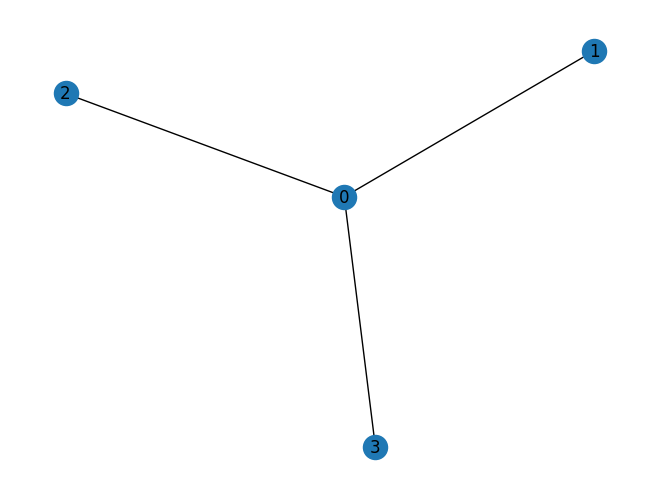

In [154]:
hamiltonian, cost_layer, graph = get_problem_qopt()
backend, initial_layout = backend_and_layout_a(cost_layer)
draw(graph, with_labels=True)

# 1. Standard Workflow

In [155]:
qaoa_circuit = qaoa_ansatz(hamiltonian, reps = 1)
qaoa_circuit.draw(fold=-1)

┌───┐                                                     ┌────────────┐
q_0: ┤ H ├─■────────────■──────────────────────────■───────────┤ Rx(2*β[0]) ├
     ├───┤ │ZZ(2*γ[0])  │           ┌────────────┐ │           └────────────┘
q_1: ┤ H ├─■────────────┼───────────┤ Rx(2*β[0]) ├─┼─────────────────────────
     ├───┤              │ZZ(2*γ[0]) ├────────────┤ │                         
q_2: ┤ H ├──────────────■───────────┤ Rx(2*β[0]) ├─┼─────────────────────────
     ├───┤                          └────────────┘ │ZZ(2*γ[0]) ┌────────────┐
q_3: ┤ H ├─────────────────────────────────────────■───────────┤ Rx(2*β[0]) ├
     └───┘                                                     └────────────┘

In [156]:
naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

In [157]:
t0 = time.time()
naive_circuit = naive_pm.run(qaoa_circuit)
t1 = time.time()
print(f"transpilation time: {t1 - t0} (s)")
print(naive_circuit.count_ops())

transpilation time: 0.0015940666198730469 (s)
OrderedDict([('rz', 19), ('sx', 12), ('cz', 6)])


In [158]:
naive_circuit.draw(fold=-1)

global phase: π
                                      ┌─────────┐┌────┐┌───────┐┌────────────┐┌────┐   ┌────────────────┐   ┌────┐  ┌──────────┐                                                                                                                                                                     
q_1 -> 0 ───────────────────────────■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├───┤ √X ├──┤ Rz(5π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                    │ └─────────┘└────┘└───────┘└────────────┘└────┘ │ └────────────────┘┌──┴────┴─┐└──┬────┬──┘┌───────┐┌────────────┐┌────┐   ┌────────────────┐   ┌────┐  ┌──────────┐                                                                                            
q_2 -> 1 ───────────────────────────┼────────────────────────────────────────────────┼─────────■─────────┤ Rz(π/2) ├───┤ √X ├───┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├───┤ √X ├──┤ Rz(5π/2) ├────────────────────────────────────────────────────────────────────────────────────────────
                                    │                                                │         │         └─────────┘   └────┘   └───────┘└────────────┘└────┘ │ └────────────────┘┌──┴────┴─┐└──┬────┬──┘┌───────┐┌────────────┐┌────┐   ┌────────────────┐      ┌────┐      ┌──────────┐            
q_3 -> 2 ───────────────────────────┼────────────────────────────────────────────────┼─────────┼──────────────────────────────────────────────────────────────┼─────────■─────────┤ Rz(π/2) ├───┤ √X ├───┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├──────┤ √X ├──────┤ Rz(5π/2) ├────────────
         ┌─────────┐┌────┐┌───────┐ │                                                │         │                                                              │         │         └─────────┘   └────┘   └───────┘└────────────┘└────┘ │ └─────┬────┬─────┘┌─────┴────┴─────┐└──┬────┬──┘┌──────────┐
q_0 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├─■────────────────────────────────────────────────■─────────■──────────────────────────────────────────────────────────────■─────────■──────────────────────────────────────────────────────────────■───────┤ √X ├──────┤ Rz(π + 2*β[0]) ├───┤ √X ├───┤ Rz(5π/2) ├
         └─────────┘└────┘└───────┘                                                                                                                                                                                                            └────┘      └────────────────┘   └────┘   └──────────┘

## Expectation Value:

In [159]:
expectation_naive = estimator.run([(naive_circuit, hamiltonian, [optimal_gamma, optimal_beta])]).result()[0].data.values()
expectation_naive

dict_values([array(0.52964542), array(0.)])

# 2. QOPT Workflow

In [160]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(cost_layer.num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(cost_layer.num_qubits)}

# 2. define pass manager for cost layer
pre_init = PassManager(
    [
        PrepareCostLayer(),
        Commuting2qGateRouter(swap_strategy, edge_coloring),
        SwapToFinalMapping(),  # Removes unnecessary SWAP gates that the end of the block
        # HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
        # InverseCancellation(gates_to_cancel=[CXGate()]),
    ]
)

# 3. define building PM
init = PassManager([QAOAConstructionPass(num_layers=1)])

In [161]:
qopt_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
qopt_pm.pre_init = pre_init
qopt_pm.init = init

In [162]:
t0_opt = time.time()
qopt_circuit = qopt_pm.run(cost_layer)
t1_opt = time.time()
print(f"transpilation time: {t1_opt - t0_opt} (s)")
print(qopt_circuit.count_ops())

transpilation time: 0.002048015594482422 (s)
OrderedDict([('rz', 32), ('sx', 28), ('cz', 11), ('measure', 4)])


In [163]:
qopt_circuit.draw(fold=-1)

global phase: 3π/2
         ┌─────────┐    ┌────┐   ┌────────────┐            ┌────┐                                                                    ┌────────┐  ┌────┐ ┌───────┐   ┌────┐  ┌─────────┐  ┌────────────────┐┌────┐┌──────────┐              ┌─┐                                                                                                                                                        
q_0 -> 0 ┤ Rz(π/2) ├────┤ √X ├───┤ Rz(2.8061) ├───────■────┤ √X ├──────────────────────────────────────────────────────────────────■─┤ Rz(-π) ├──┤ √X ├─┤ Rz(π) ├─■─┤ √X ├──┤ Rz(π/2) ├──┤ Rz(π + 2*β[0]) ├┤ √X ├┤ Rz(5π/2) ├──────────────┤M├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         ├─────────┤    ├────┤   └────────────┘┌────┐ │    └────┘  ┌────────┐   ┌────┐    ┌──────────┐          ┌────┐   ┌───────┐ │ └────────┘  └────┘ └───────┘ │ └────┘  └─────────┘  └────────────────┘└────┘└──────────┘              └╥┘                                             ┌────┐ ┌───────┐  ┌────────────┐┌────┐   ┌────────────────┐      ┌────┐      ┌──────────┐            ┌─┐   
q_3 -> 1 ┤ Rz(π/2) ├────┤ √X ├─────────■───────┤ √X ├─┼──────■─────┤ Rz(-π) ├───┤ √X ├────┤ Rz(-π/2) ├───■──────┤ √X ├───┤ Rz(π) ├─┼──────────────────────────────┼─────────────────────────────────────────────────────────────────────────╫────────────────────────────────────■─────────┤ √X ├─┤ Rz(π) ├──┤ Rz(2*γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├──────┤ √X ├──────┤ Rz(5π/2) ├────────────┤M├───
         └──┬────┬─┘┌───┴────┴──┐      │       ├────┤ │      │     └─┬────┬─┘   └────┘    └──────────┘   │    ┌─┴────┴┐  └───────┘ │                              │                                        ┌────┐ ┌────────┐ ┌────────────┐ ║    ┌────┐┌───────┐   ┌────┐        │         └────┘ └───────┘  └────────────┘└────┘ │ └─────┬────┬─────┘┌─────┴────┴─────┐└──┬────┬──┘┌──────────┐└╥┘┌─┐
q_2 -> 2 ───┤ √X ├──┤ Rz(-3π/2) ├──────■───────┤ √X ├─┼──────■───────┤ √X ├──────────────────────────────■────┤ Rz(π) ├────────────┼──────────────────────────────┼──────────────────────────────■─────────┤ √X ├─┤ Rz(-π) ├─┤ Rz(2*γ[0]) ├─╫──■─┤ √X ├┤ Rz(π) ├─■─┤ √X ├────────■────────────────────────────────────────────────■───────┤ √X ├──────┤ Rz(π + 2*β[0]) ├───┤ √X ├───┤ Rz(5π/2) ├─╫─┤M├
            └────┘  └───────────┘              └────┘ │ ┌─────────┐  ├────┤  ┌──────────┐┌────────────┐┌────┐┌┴───────┴─┐          │   ┌────┐  ┌───────┐          │ ┌────┐┌─────────────┐        │         ├────┤ ├────────┤ └────────────┘ ║  │ ├────┤├───────┤ │ ├────┤┌────────────────┐┌────┐┌──────────┐     ┌─┐                     └────┘      └────────────────┘   └────┘   └──────────┘ ║ └╥┘
q_1 -> 3 ─────────────────────────────────────────────■─┤ Rz(π/2) ├──┤ √X ├──┤ Rz(-π/2) ├┤ Rz(2*γ[0]) ├┤ √X ├┤ Rz(-π/2) ├──────────■───┤ √X ├──┤ Rz(π) ├──────────■─┤ √X ├┤ Rz(0.33545) ├────────■─────────┤ √X ├─┤ Rz(-π) ├────────────────╫──■─┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π + 2*β[0]) ├┤ √X ├┤ Rz(5π/2) ├─────┤M├────────────────────────────────────────────────────────────────────────────╫──╫─
                                                        └─────────┘  └────┘  └──────────┘└────────────┘└────┘└──────────┘              └────┘  └───────┘            └────┘└─────────────┘                  └────┘ └────────┘                ║    └────┘└───────┘   └────┘└────────────────┘└────┘└──────────┘     └╥┘                                                                            ║  ║ 
    c: 4/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══════════════════════════════════════════════════════════════════════╩═════════════════════════════════════════════════════════════════════════════╩══╩═
                                                                       

## Expectation Value:

In [164]:
qopt_circuit.remove_final_measurements()
expectation_qopt = estimator.run([(qopt_circuit, hamiltonian, [optimal_gamma, optimal_beta])]).result()[0].data.values()
expectation_qopt

/Users/ept/qiskit_workspace/qopt-best-practices/.venv/lib/python3.11/site-packages/qiskit/circuit/quantumcircuit.py:4625: UserWarning: Trying to add QuantumRegister to a QuantumCircuit having a layout
  circ.add_register(qreg)


dict_values([array(0.52964542), array(0.)])

# 3. Annotated Workflow

AM I PRINTING
USE BOX
AM I PRINTING
USE BOX


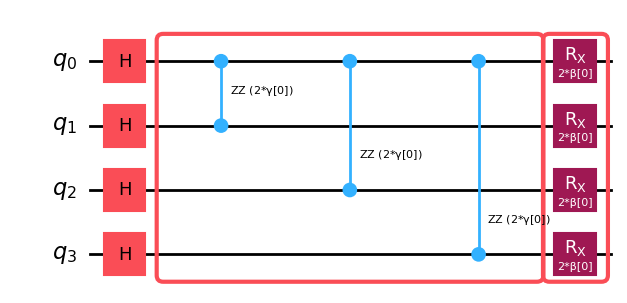

In [165]:
annotated_ansatz = annotated_qaoa_ansatz(hamiltonian, reps = 1)
annotated_ansatz.draw('mpl', fold=-1)

In [168]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(cost_layer.num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(cost_layer.num_qubits)}

# 2. define pass manager for cost layer
pre_init = PassManager(
    [
        AnnotatedPrepareCostLayer(),
        AnnotatedCommuting2qGateRouter(swap_strategy, edge_coloring),
        SwapToFinalMapping(),  # Removes unnecessary SWAP gates that the end of the block
        # HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
        # InverseCancellation(gates_to_cancel=[CXGate()]),
    ]
)
init = PassManager([])

In [169]:
annotated_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
annotated_pm.pre_init = pre_init
annotated_pm.init = init

In [170]:
t0_opt = time.time()
annotated_circuit = annotated_pm.run(annotated_ansatz)
t1_opt = time.time()
print(f"transpilation time: {t1_opt - t0_opt} (s)")
print(annotated_circuit.count_ops())

GATE LAYERS defaultdict(<class 'dict'>, {np.int64(0): {(0, 1): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x137621d70>])}, np.int64(2): {(0, 2): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x13757b690>])}, np.int64(1): {(0, 3): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x13786fe70>])}})
transpilation time: 0.0025453567504882812 (s)
OrderedDict([('rz', 32), ('sx', 28), ('cz', 11)])


In [171]:
annotated_circuit.draw(fold=-1)

global phase: 3π/2
         ┌─────────┐    ┌────┐   ┌────────────┐            ┌────┐                                                                    ┌────────┐  ┌────┐ ┌───────┐   ┌────┐  ┌─────────┐  ┌────────────────┐┌────┐┌──────────┐                                                                                                                                                                
q_0 -> 0 ┤ Rz(π/2) ├────┤ √X ├───┤ Rz(2.8061) ├───────■────┤ √X ├──────────────────────────────────────────────────────────────────■─┤ Rz(-π) ├──┤ √X ├─┤ Rz(π) ├─■─┤ √X ├──┤ Rz(π/2) ├──┤ Rz(π + 2*β[0]) ├┤ √X ├┤ Rz(5π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         ├─────────┤    ├────┤   └────────────┘┌────┐ │    └────┘  ┌────────┐   ┌────┐    ┌──────────┐          ┌────┐   ┌───────┐ │ └────────┘  └────┘ └───────┘ │ └────┘  └─────────┘  └────────────────┘└────┘└──────────┘                                                           ┌────┐ ┌───────┐  ┌────────────┐┌────┐   ┌────────────────┐      ┌────┐      ┌──────────┐            
q_3 -> 1 ┤ Rz(π/2) ├────┤ √X ├─────────■───────┤ √X ├─┼──────■─────┤ Rz(-π) ├───┤ √X ├────┤ Rz(-π/2) ├───■──────┤ √X ├───┤ Rz(π) ├─┼──────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────┤ √X ├─┤ Rz(π) ├──┤ Rz(2*γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├──────┤ √X ├──────┤ Rz(5π/2) ├────────────
         └──┬────┬─┘┌───┴────┴──┐      │       ├────┤ │      │     └─┬────┬─┘   └────┘    └──────────┘   │    ┌─┴────┴┐  └───────┘ │                              │                                        ┌────┐ ┌────────┐ ┌────────────┐   ┌────┐┌───────┐   ┌────┐        │         └────┘ └───────┘  └────────────┘└────┘ │ └─────┬────┬─────┘┌─────┴────┴─────┐└──┬────┬──┘┌──────────┐
q_2 -> 2 ───┤ √X ├──┤ Rz(-3π/2) ├──────■───────┤ √X ├─┼──────■───────┤ √X ├──────────────────────────────■────┤ Rz(π) ├────────────┼──────────────────────────────┼──────────────────────────────■─────────┤ √X ├─┤ Rz(-π) ├─┤ Rz(2*γ[0]) ├─■─┤ √X ├┤ Rz(π) ├─■─┤ √X ├────────■────────────────────────────────────────────────■───────┤ √X ├──────┤ Rz(π + 2*β[0]) ├───┤ √X ├───┤ Rz(5π/2) ├
            └────┘  └───────────┘              └────┘ │ ┌─────────┐  ├────┤  ┌──────────┐┌────────────┐┌────┐┌┴───────┴─┐          │   ┌────┐  ┌───────┐          │ ┌────┐┌─────────────┐        │         ├────┤ ├────────┤ └────────────┘ │ ├────┤├───────┤ │ ├────┤┌────────────────┐┌────┐┌──────────┐                             └────┘      └────────────────┘   └────┘   └──────────┘
q_1 -> 3 ─────────────────────────────────────────────■─┤ Rz(π/2) ├──┤ √X ├──┤ Rz(-π/2) ├┤ Rz(2*γ[0]) ├┤ √X ├┤ Rz(-π/2) ├──────────■───┤ √X ├──┤ Rz(π) ├──────────■─┤ √X ├┤ Rz(0.33545) ├────────■─────────┤ √X ├─┤ Rz(-π) ├────────────────■─┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π + 2*β[0]) ├┤ √X ├┤ Rz(5π/2) ├───────────────────────────────────────────────────────────────────────────────────
                                                        └─────────┘  └────┘  └──────────┘└────────────┘└────┘└──────────┘              └────┘  └───────┘            └────┘└─────────────┘                  └────┘ └────────┘                  └────┘└───────┘   └────┘└────────────────┘└────┘└──────────┘

## Expectation Value:

In [172]:
expectation_annotated = estimator.run([(annotated_circuit, hamiltonian, [optimal_gamma, optimal_beta])]).result()[0].data.values()
expectation_annotated

dict_values([array(0.52964542), array(0.)])

# EXPECTATION VALUE COMPARISON

In [173]:
expectation_naive

dict_values([array(0.52964542), array(0.)])

In [175]:
expectation_qopt

dict_values([array(0.52964542), array(0.)])

In [174]:
expectation_annotated

dict_values([array(0.52964542), array(0.)])